In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display as display
import librosa.feature
import sys
import os
import math

In [2]:
import soundfile as sf

def import_audio(filename): #Fungsi untuk ekstrak data time series dari audio
    """
    Extract audio given the filename (.wav, .flac, etc format)
    """

    audio, rate = sf.read(filename, always_2d=True)
    audio = np.reshape(audio, (1, -1))
    audio = audio[0]
    time = np.linspace(0, len(audio)/rate, len(audio), endpoint=False)
    return audio, rate, time

In [3]:
female_filename = 'classification/cough/test_010.wav'
male_filename = 'sample_noise/noise-free-sound-0001.wav'

In [4]:
female, female_rate, female_time = import_audio(female_filename)
male, _, _ = import_audio(male_filename)
male = male[0:len(female)]

In [5]:
male.shape

(92800,)

In [6]:
import math 

# male addition
def add_male(audio, male, snr, rate): #Fungis untuk penambahan male atau dengan kata lain mixing audio
    """
    Add male to female signal at certain SNR
    audio_filename: female audio filename 
    male_filename: male audio filename
    snr: desired signal to male ratio
    """
    # audio, audio_time, audio_rate = extract_audio(audio_filename)
    # male, male_time, male_rate = extract_audio(male_filename)

    male = male[0:audio.shape[0]]

    if len(audio) > len(male):
        male_add = male[0:(len(audio)-len(male))]
        male = np.append(male, male_add)

    audio_RMS = rmsValue(audio,len(audio))
    male_RMS = rmsValue(male,len(male))

    male_RMS_new = audio_RMS / pow(10,(snr/20))

    male = male*(male_RMS_new/male_RMS)

    snr_check = 20 * np.log10(audio_RMS/rmsValue(male,len(male)))

    print("male added with SNR = " + str(round(snr_check)))

    maled = audio + male
    maled_rate = rate

    return maled, maled_rate, round(snr_check)

#Function that Calculate Root Mean Square, This code is contributed by Shashank_Sharma
def rmsValue(arr, n):
    square = 0
    mean = 0.0
    root = 0.0
     
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)
     
    #Calculate Mean
    mean = (square / (float)(n))
     
    #Calculate Root
    root = math.sqrt(mean)
     
    return root
 
# audio padding
def pad(audio, pad_length):
    shape = np.shape(audio)
    padded_audio = np.zeros(pad_length)
    padded_audio[0:shape[0]] = audio

    return padded_audio

In [7]:
SNR = 15
mixture, _, _ = add_male(female, male, SNR, female_rate)

male added with SNR = 15


In [8]:
def extract_tf_mask(female, male, n_fft=1024, hop_length=512, win_length=1024):
    """
    Generate mask using librosa (magnitude of STFT)
    female: female audio
    n_fft: number of fft-point
    hop_length: overlap length of STFT
    win_length: window length of STFT
    mask_type: soft mask
    """

    y = librosa.stft(female, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    n = librosa.stft(male, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    e = 1e-6

    mask = ((np.abs(y)) / (np.abs(n)))
    
    n_frames = abs(n).shape[-1]

    return y, n, mask, n_frames

In [9]:
def graph_stft(audio_mag, title=False):
    """
    plot spectrogram
    spec: spectrogram generated using Librosa
    rate: sampling rate
    """
    plt.figure()
    display.specshow(librosa.amplitude_to_db(audio_mag, ref=np.mean), y_axis='log', x_axis='time')
    # display.specshow(audio_mag, y_axis='log', x_axis='time')
    
    plt.colorbar(format="%+2.0f dB")
    if (title):
        plt.title('Power Spectrogram')
    plt.tight_layout()

In [10]:
female_tf, mixtured_tf, tf_mask, _ = extract_tf_mask(female, male)

In [11]:
female_coba = mixtured_tf * tf_mask
female_istft = librosa.istft(female_coba, hop_length=512, win_length=1024)

C:\Users\Zanja\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


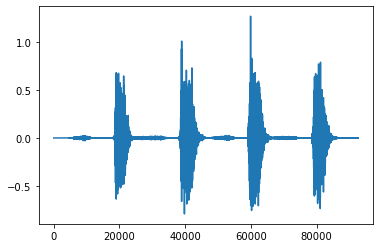

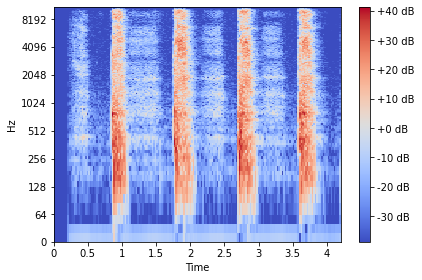

In [12]:
plt.plot(female_istft)
graph_stft(female_tf)
ipd.Audio(female_istft, rate=female_rate)

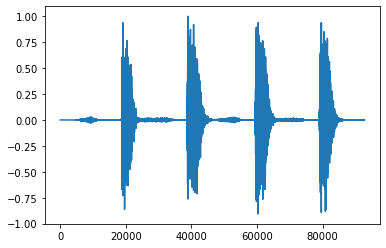

In [13]:
plt.plot(female)
ipd.Audio(female, rate=female_rate)

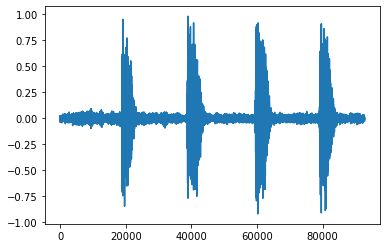

In [14]:
plt.plot(mixture)
ipd.Audio(mixture, rate=female_rate)

In [163]:
import os
import sys
import librosa as lb
sys.path.append(os.path.abspath('script'))
from feature_class import features
from DSP import classify_cough
from scipy.io import wavfile
import pickle
import shutil
import pandas as pd

In [165]:
loaded_model = pickle.load(open(os.path.join('models', 'cough_classifier'), 'rb'))
loaded_scaler = pickle.load(open(os.path.join('models','cough_classification_scaler'), 'rb'))

In [203]:
probability = classify_cough(female_istft, female_rate, loaded_model, loaded_scaler)
value = round(probability*100,2)
print(value)

84.42
